# Poiseuille flow example
This is an example of using the Poiseuille flow
A two dimensional Poiseuille flow is initialized and simulated. Afterwards the energy and the velocity field is plotted.

In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch

## Setup
* for running on GPU: device = "cuda". CUDA drivers are required!
* dtype=torch.float32 for single precision - float64 for double precision
* select collision model (here BGKCollision) - try also KBCCollision or RegularizedCollision

### Code:
* Reporters will grab the results in between simulation steps (see reporters.py and simulation.py)
* Output: Column 1: simulation steps, Column 2: time in LU, Column 3: kinetic energy in PU
* Output: separate VTK-file with ux,uy,(uz) and p for every 100. time step in ./output

In [2]:
nmax     = 20000
nconsole = 100
nreport  = 100
epsilon  = 0.001 # convergence condition: .1 % relative change

lattice = lt.Lattice(lt.D2Q9, device = torch.device("cuda"), dtype=torch.float64, use_native=False)
flow = lt.PoiseuilleFlow2D(resolution=16, reynolds_number=1, mach_number=0.02, lattice=lattice)
acceleration_lu = flow.units.convert_acceleration_to_lu(flow.acceleration)
force = lt.ShanChen(lattice, tau=flow.units.relaxation_parameter_lu,
                  acceleration=acceleration_lu)
collision = lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu, force=force)
streaming = lt.StandardStreaming(lattice)
simulation = lt.Simulation(flow=flow, lattice=lattice, collision=collision, streaming=streaming)

Energy = lt.IncompressibleKineticEnergy(lattice, flow)
energy_reporter_internal = lt.ObservableReporter(Energy, interval=nreport, out=None)
simulation.reporters.append(energy_reporter_internal)
simulation.reporters.append(lt.ObservableReporter(Energy, interval=nconsole)) # print energy
simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=nreport, filename_base="./data/poiseuille/out"))

steps     time     IncompressibleKineticEnergy
steps     time     IncompressibleKineticEnergy


## Run simulation

In [3]:
simulation.initialize_f_neq()
energy_new = 0
mlups = 0
iterations = int(nmax//nconsole)
for _ in range(iterations):
    energy_old = energy_new
    energy_new = Energy(simulation.f).mean()
    mlups += simulation.step(nconsole)
    if abs((energy_new - energy_old)/energy_new) < epsilon:
        print("CONVERGENCE! Less than ", epsilon*100, " % relative change")
        break
print("avg MLUPS: ", mlups/iterations)

0 0.0 0.0
100 0.07216878364870323 9.909340968468728e-10
200 0.14433756729740646 2.0629821599380966e-09
300 0.2165063509461097 2.665080671936491e-09
400 0.2886751345948129 2.9576571846563504e-09
500 0.3608439182435162 3.092687466056564e-09
600 0.4330127018922194 3.1537139106196866e-09
700 0.5051814855409227 3.1810481207676734e-09
800 0.5773502691896258 3.193243341608845e-09
900 0.6495190528383291 3.1986748430123624e-09
1000 0.7216878364870324 3.2010920642647115e-09
1100 0.7938566201357355 3.2021674502234276e-09
CONVERGENCE! Less than  0.1  % relative change
avg MLUPS:  0.02166252193834579


## Post process
### Energy Reporter
* Grab output of kinetic energy reporter

(12, 3)


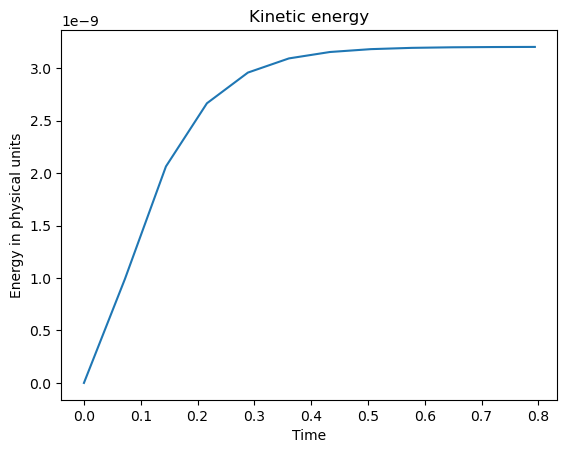

In [4]:
energy = np.array(simulation.reporters[0].out)
print(energy.shape)
plt.plot(energy[:,1],energy[:,2])
plt.title('Kinetic energy')
plt.xlabel('Time')
plt.ylabel('Energy in physical units')
plt.show()

### Velocity
We calculate the speed in Lettuce units depending on the last 'f'. Then we convert this velocity into physical units. For further investigations the tensor must be converted into a Numpy-Array. The norm of the fractions in x and y direction is plotted afterwards.

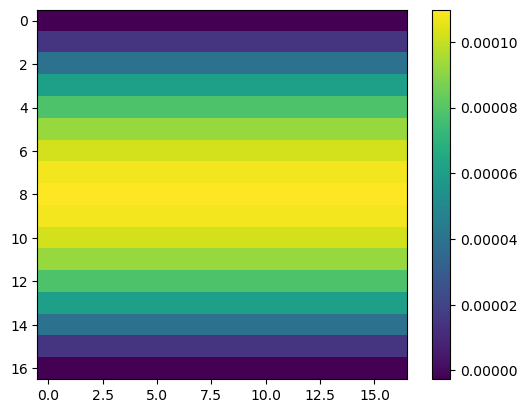

In [6]:
u_x = flow.units.convert_velocity_to_pu(lattice.u(simulation.f)).cpu().numpy()[0]
plt.imshow(u_x.transpose())
plt.colorbar()
plt.show()